<a href="https://colab.research.google.com/github/Uneto47/PLN_2024_Datasets_Desbalanceados_Neto_Unaldo/blob/main/C%C3%B3pia_de_Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import faiss


from google.colab import files

df_issues = pd.read_csv("/content/chatgpt_review.csv", nrows=15000)
print(f"DataFrame shape: {df_issues.shape}")

DataFrame shape: (15000, 6)


In [6]:
("a) Campos que compõem cada registro:")
print(df_issues.columns.tolist())

['Unnamed: 0', 'userName', 'content', 'score', 'thumbsUpCount', 'at']


In [7]:
score_to_label = {
    5: 'Excelente',
    4: 'Bom',
    3: 'Mediano',
    2: 'Ruim',
    1: 'Péssimo'
}

df_issues['score'] = df_issues['score'].map(score_to_label)

labels = df_issues['score'].unique()
print("b) Labels das classes existentes:")
print(labels)

b) Labels das classes existentes:
[nan 'Excelente' 'Péssimo' 'Mediano' 'Ruim' 'Bom']


In [8]:
df_issues["num_labels"] = df_issues["score"].apply(lambda x: 0 if pd.isna(x) else 1)

print("c) Quantidade de registros por número de labels:")
label_counts = df_issues["num_labels"].value_counts().sort_index().to_frame().T
print(label_counts)


c) Quantidade de registros por número de labels:
num_labels      0     1
count       13453  1547


In [9]:
print("d) Quantidade de registros associados a cada label/classe existente:")
label_frequency = df_issues["score"].explode().value_counts()
print(label_frequency)

d) Quantidade de registros associados a cada label/classe existente:
score
Excelente    1140
Bom           181
Péssimo       123
Mediano        66
Ruim           37
Name: count, dtype: int64


In [10]:
print("e) Quantidade de registros com labels/classes e sem labels/classes:")
with_labels_count = df_issues["score"].notna().sum()
without_labels_count = df_issues["score"].isna().sum()
print(f"Com labels: {with_labels_count}")
print(f"Sem labels: {without_labels_count}")

e) Quantidade de registros com labels/classes e sem labels/classes:
Com labels: 1547
Sem labels: 13453


In [11]:
print("4º) Identifique quais labels/classes serão utilizados na atividade de classificação a ser realizada. \n Aplique um filtro apropriado para uso destes registros na atividade\n")

label_map = {
    "Excelente" : "excelente",
    "Ruim": "ruim",
    "Péssimo": "pessimo",
    "Bom": "bom",
    "Mediano": "mediano",
}

print("Labels utilizadas: ", list(label_map.keys()))

def filter_labels(label):
    return label_map.get(label, None)

df_issues["score"] = df_issues["score"].apply(filter_labels)
all_labels = list(label_map.values())
df_counts = df_issues["score"].value_counts()
result = df_counts.to_frame().T
print(result)
print(df_issues["score"].isna().sum())

4º) Identifique quais labels/classes serão utilizados na atividade de classificação a ser realizada. 
 Aplique um filtro apropriado para uso destes registros na atividade

Labels utilizadas:  ['Excelente', 'Ruim', 'Péssimo', 'Bom', 'Mediano']
score  excelente  bom  pessimo  mediano  ruim
count       1140  181      123       66    37
13453


In [12]:
print("5º)Crie uma nova coluna no dataframe do Pandas que você está utilizando \n para indicar se o registro possui label ou não.\n")
df_issues["split"] = "unlabeled"
mask = df_issues["score"].apply(lambda x: len(x) if x is not None else 0) > 0
df_issues.loc[mask, "split"] = "labeled"
split_counts = df_issues["split"].value_counts().to_frame()
print(split_counts)

5º)Crie uma nova coluna no dataframe do Pandas que você está utilizando 
 para indicar se o registro possui label ou não.

           count
split           
unlabeled  13453
labeled     1547


In [13]:
print("6º)Caso dois ou mais campos contenham informação textual de interesse para a análise,\n avalie a possibilidade de concatená-los em um único campo.\n")
cols = ["userName", "content"]

df_issues["text"] = (df_issues
                    .apply(lambda x: x["userName"] + "\n\n" + x["content"], axis=1))

print(df_issues[["text"]].head(3))

6º)Caso dois ou mais campos contenham informação textual de interesse para a análise,
 avalie a possibilidade de concatená-los em um único campo.

                                             text
0   T H (Trudylh20)\n\nexcellent Im impressed 👌 👏
1                 Muhammad bassam adam\n\nperfect
2  Chinaza Okoli\n\nits been so helpful...love it


In [14]:
print("7º)Identifique possíveis registros duplicados e remova-os.\n")
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset="text")
print(f"Removed {(len_before-len(df_issues))/len_before:.2%} duplicates.")

7º)Identifique possíveis registros duplicados e remova-os.

Removed 0.09% duplicates.


8º)Apresente um gráfico para mostrar a distribuição de quantidade de palavras por registro.


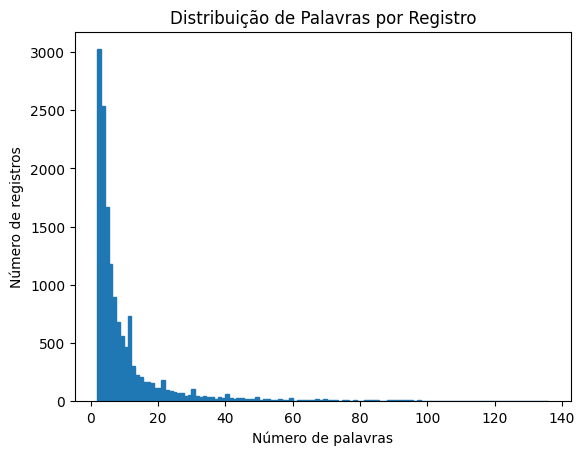

In [15]:
print("8º)Apresente um gráfico para mostrar a distribuição de quantidade de palavras por registro.")

(df_issues["text"].str.split().apply(len)
 .hist(bins=120, grid=False, edgecolor="C0"))
plt.title("Distribuição de Palavras por Registro")
plt.xlabel("Número de palavras")
plt.ylabel("Número de registros")
plt.show()

In [16]:
!pip install scikit-multilearn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split

mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["bom"], ["pessimo","ruim"], ["mediano"]])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 4.9 MB/s eta 0:00:00


array([[1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 1, 0, 0]])

In [17]:
def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["score"])
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels,
                                                           test_size)
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:,0]]

df_clean = df_issues[["text", "score", "split"]].reset_index(drop=True).copy()
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "score"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "score"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['a', 'b', 'c', 'd', 'e', 'i', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'x'] will be ignored
  warnings.warn(


In [18]:
!pip install datasets
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))})

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.8 MB/s eta 0:00:00


In [19]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["score"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
        indices_pool, labels, (k-last_k)/len(labels))
    last_k = k
    if i==0: train_slices.append(new_slice)
    else: train_slices.append(np.concatenate((train_slices[-1], new_slice)))

train_slices.append(all_indices), train_samples.append(len(ds["train"]))
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['a', 'b', 'c', 'd', 'e', 'i', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'x'] will be ignored
  warnings.warn(


In [20]:
print("Target split sizes:")
print(train_samples)
print("Actual split sizes:")
print([len(x) for x in train_slices])

Target split sizes:
[8, 16, 32, 64, 128, 774]
Actual split sizes:
[8, 16, 32, 64, 128, 774]


In [21]:
def prepare_labels(batch):
    batch["label_ids"] = mlb.transform([[s] if s is not None else [] for s in batch["score"]])
    return batch

ds = ds.map(prepare_labels, batched=True)

Map:   0%|          | 0/774 [00:00<?, ? examples/s]

Map:   0%|          | 0/387 [00:00<?, ? examples/s]

Map:   0%|          | 0/386 [00:00<?, ? examples/s]

Map:   0%|          | 0/13439 [00:00<?, ? examples/s]

In [22]:
from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)

In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

for train_slice in train_slices:
    ds_train_sample = ds["train"].select(train_slice)
    y_train = np.array(ds_train_sample["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_sample["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
        output_dict=True)
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

In [24]:
last_micro_f1 =  micro_scores["Naive Bayes"][-1]
last_macro_f1 =  macro_scores["Naive Bayes"][-1]

print("Micro F1 Score:", last_micro_f1,"Macro F1 Score:", last_macro_f1)

Micro F1 Score: 0.7369901547116737 Macro F1 Score: 0.1732231404958678


In [25]:
import matplotlib.pyplot as plt

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run,
                     linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run,
                     linestyle="dashed")

    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()

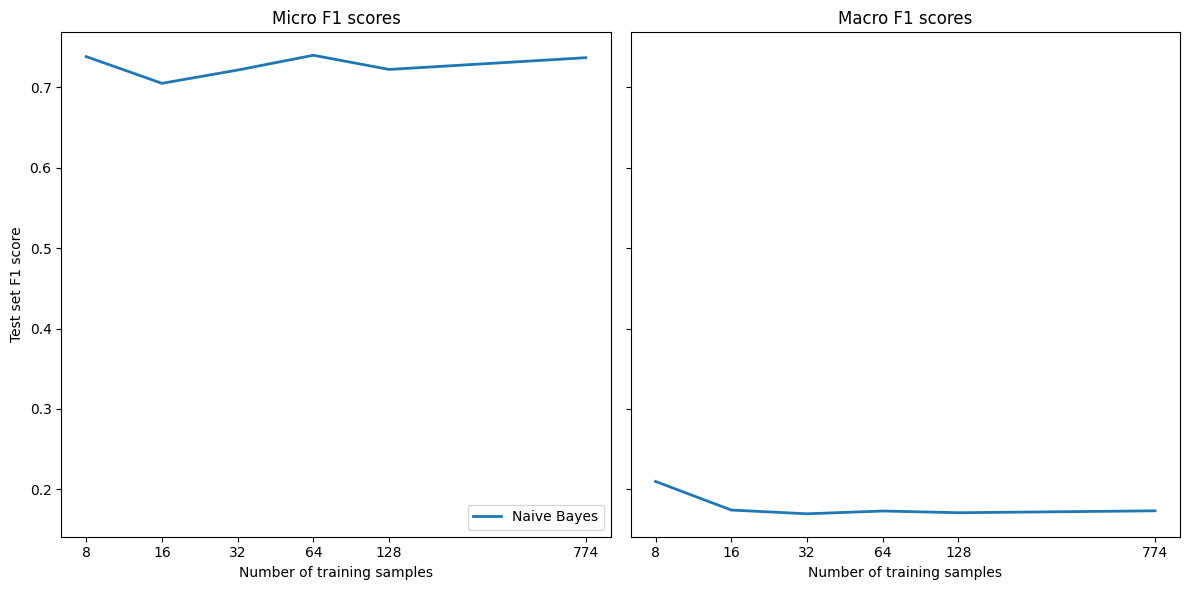

In [26]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")

In [27]:
import torch
from transformers import AutoTokenizer, AutoModel

model_ckpt = "miguelvictor/python-gpt2-large"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = (attention_mask
                           .unsqueeze(-1)
                           .expand(token_embeddings.size())
                           .float())
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def embed_text(examples):
    inputs = tokenizer(examples["text"], padding=True, truncation=True,
                       max_length=128, return_tensors="pt")
    with torch.no_grad():
        model_output = model(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/792 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

In [30]:
tokenizer.pad_token = tokenizer.eos_token
embs_train = ds["train"].map(embed_text, batched=True, batch_size=16)
embs_valid = ds["valid"].map(embed_text, batched=True, batch_size=16)
embs_test = ds["test"].map(embed_text, batched=True, batch_size=16)

Map:   0%|          | 0/774 [00:00<?, ? examples/s]

Map:   0%|          | 0/387 [00:00<?, ? examples/s]

Map:   0%|          | 0/386 [00:00<?, ? examples/s]

In [31]:
embs_train.add_faiss_index("embedding")

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['text', 'score', 'label_ids', 'embedding'],
    num_rows: 774
})

In [32]:

i, k = 0, 3 # Select the first query and 3 nearest neighbors
rn, nl = "\r\n\r\n", "\n" # Used to remove newlines in text for compact display

query =  np.array(embs_valid[i]["embedding"], dtype=np.float32)
scores, samples = embs_train.get_nearest_examples("embedding", query, k=k)

print(f"QUERY LABELS: {embs_valid[i]['score']}")
print(f"QUERY TEXT:\n{embs_valid[i]['text'][:200].replace(rn, nl)} [...]\n")
print("="*50)
print(f"Retrieved documents:")
for score, label, text in zip(scores, samples["score"], samples["text"]):
    print("="*50)
    print(f"TEXT:\n{text[:200].replace(rn, nl)} [...]")
    print(f"SCORE: {score:.2f}")
    print(f"LABELS: {label}")


QUERY LABELS: excelente
QUERY TEXT:
Laveral King II

helpful whenever bored or needs [...]

Retrieved documents:
TEXT:
Saviour Alamene

Great source for knowledge and ideas 💡 [...]
SCORE: 109.86
LABELS: excelente
TEXT:
Laresa Perryman

ChatGPT is great better than Serie and Google Excellent 👌👍💯 [...]
SCORE: 110.16
LABELS: excelente
TEXT:
Nithin Joshua

Very useful when teacher's give us work to do [...]
SCORE: 110.22
LABELS: bom


In [33]:

def get_sample_preds(sample, m):
    return (np.sum(sample["label_ids"], axis=0) >= m).astype(int)

def find_best_k_m(ds_train, valid_queries, valid_labels, max_k=17):
    max_k = min(len(ds_train), max_k)
    perf_micro = np.zeros((max_k, max_k))
    perf_macro = np.zeros((max_k, max_k))
    for k in range(1, max_k):
        for m in range(1, k + 1):
            _, samples = ds_train.get_nearest_examples_batch("embedding",
                                                             valid_queries, k=k)
            y_pred = np.array([get_sample_preds(s, m) for s in samples])
            clf_report = classification_report(valid_labels, y_pred,
                target_names=mlb.classes_, zero_division=0, output_dict=True)
            perf_micro[k, m] = clf_report["micro avg"]["f1-score"]
            perf_macro[k, m] = clf_report["macro avg"]["f1-score"]
    return perf_micro, perf_macro

In [34]:
valid_labels = np.array(embs_valid["label_ids"])
valid_queries = np.array(embs_valid["embedding"], dtype=np.float32)
perf_micro, perf_macro = find_best_k_m(embs_train, valid_queries, valid_labels)

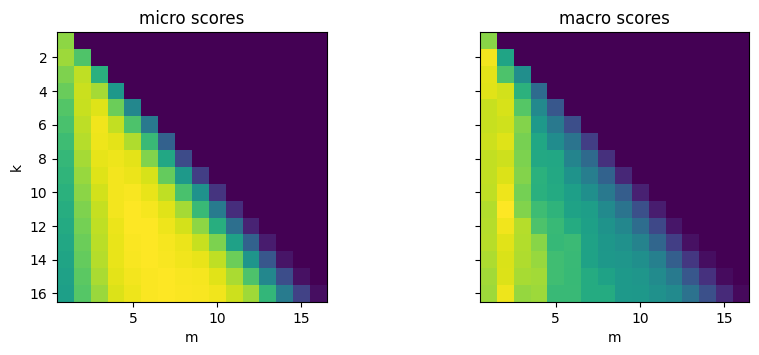

In [35]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
ax0.imshow(perf_micro)
ax1.imshow(perf_macro)

ax0.set_title("micro scores")
ax0.set_ylabel("k")
ax1.set_title("macro scores")
for ax in [ax0, ax1]:
    ax.set_xlim([0.5, 17 - 0.5])
    ax.set_ylim([17 - 0.5, 0.5])
    ax.set_xlabel("m")
plt.show()

In [36]:
k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
print(f"Best k: {k}, best m: {m}")

Best k: 11, best m: 5


In [37]:
embs_train.drop_index("embedding")
test_labels = np.array(embs_test["label_ids"])
test_queries = np.array(embs_test["embedding"], dtype=np.float32)

for train_slice in train_slices:
    # Create a FAISS index from training slice
    embs_train_tmp = embs_train.select(train_slice)
    embs_train_tmp.add_faiss_index("embedding")
    # Get best k, m values with validation set
    perf_micro, _ = find_best_k_m(embs_train_tmp, valid_queries, valid_labels)
    k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
    # Get predictions on test set
    _, samples = embs_train_tmp.get_nearest_examples_batch("embedding",
                                                           test_queries,
                                                           k=int(k))
    y_pred = np.array([get_sample_preds(s, m) for s in samples])
    # Evaluate predictions
    clf_report = classification_report(test_labels, y_pred,
        target_names=mlb.classes_, zero_division=0, output_dict=True,)
    macro_scores["Embedding"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Embedding"].append(clf_report["micro avg"]["f1-score"])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Micro F1 Score: 0.7330677290836654 Macro F1 Score: 0.17116279069767443



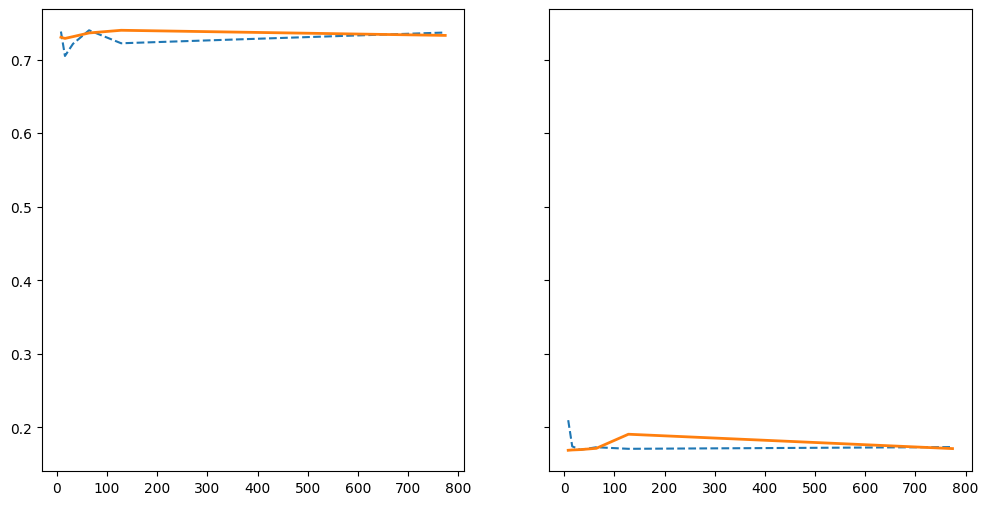

In [59]:
last_micro =  micro_scores["Embedding"][-1]
last_macro =  macro_scores["Embedding"][-1]

print("Micro F1 Score:", last_micro,"Macro F1 Score:", last_macro)

plot_metrics(micro_scores, macro_scores, train_samples, "Embedding")